In [94]:
# python imports
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
from scipy.stats import linregress

In [2]:
# hide warnings
import warnings
warnings.filterwarnings('ignore')

In [115]:
# matplotlib theming
import mplcyberpunk
from mplcyberpunk import add_glow_effects

# to use theme: pip install mplcyberpunk
plt.style.use("cyberpunk")
# change default plot size
plt.rcParams["figure.figsize"] = (12, 3.8)

# Workshop on Weather and Climate Services <a id="top"></a>

A practical workshop using weather and climate data to support decision-making in the energy sector.

**icem 2023** 7th International Conference Energy & Meteorology  
*Towards Climate-Resilient Energy Systems*

## Programme

*Tuesday 27th June 16:15-18:00 CEST*  
**Convenors: James Fallon and Jake Badger**

| Time | Activity | Speaker |
| --- | --- | --- |
| 16:15 | Introduction | Jake |
| 16:20 | Overview of Live Climate Services | Jake |
| 16:40 | Interactive Session: Climate Services Notebook | James |
| 17:20 | Discussion: the "Next Generation" of Climate Services | Abstract Author |
| 17:55 | Closing remarks | Jake & James |

## About these slides

View as `PDF` / `html` or run `ipynb` with instructions at:

<table width=100% height=100% style="font-size: 38px";><tr><td width=30%><a href="https://github.com/jfallon1997/ICEM-2023-ClimateServicesWorkshop"><center><img src="github_qr.png" width="60%"></center></a></td><td width=70%><center><a href="https://qrco.de/bdxJdJ">https://qrco.de/bdxJdJ</a><br><br><a href="https://github.com/jfallon1997/ICEM-2023-ClimateServicesWorkshop">https://github.com/jfallon1997/<br>ICEM-2023-ClimateServicesWorkshop</a></center></td></tr></table>

## Introduction

**todo: insert Jake's relevant slides**

### "what is a climate service"

*A decision aide derived from climate infromation*<sup>[1](https://public.wmo.int/en/bulletin/what-do-we-mean-climate-services)</sup>

Example slides and shcematics here: <https://www.wemcouncil.org/TALKS/EEA_Troccoli_Copenhagen_Sep2018.pdf>



#### Definition of Climate Services adopted by the ScienceDirect Climate Services journal (open access)

"the transformation of climate-related data - together with other relevant information - into customized products such as projections, forecasts, information, trends, economic analysis, assessments (including technology assessment), counselling on best practices development and evaluation of solutions and any other services in relation to climate that may be use for the society at large."

source: European Commission's Roadmap for Climate Services (2015).

### "what is a climate service used for"

* see preivously linked slides - take some examples
* any examples from submitted abstracts?
* other ideas?

### "what we will cover today"

* how to **access and use** some climate services
* exploring the **impact chain**: from weather data to energy variables
* **common misconceptions** / things to be aware of!

## Overview of Live Climate Services

**todo: insert Jake's relevant slides**

### eg. COPERNICUS API / ECEM / C4E

<center><img src="screenshots/COPERNICUS_ECEM_demo_1.png" width="60%"></center>

### eg. NASA POWER

<center><img src="screenshots/NASA_POWER_demo_1.png" width="80%"></center>

### Climate services presented at ICEM23

| Service | Abstract Author(s) | Other info | License / access |
| --- | --- | --- | --- |
| MeteoIA | Gabriel Perez | https://meteoia.com | Paid Service |
| Copernicus ECEM | ??? | http://ecem.wemcouncil.org | Public webapp |
| NASA POWER | ??? | ??? | Public webapp |
| List to be extended | ... | eg. url | ... |



## Interactive Session Part 1: Working with Meteorological Data

We will show how to read in wind data - but a similar process can be considered for solar irradiance, temperature, and other energy-relevant variables

### Downloading data...

In this example, we use the **NASA POWER DAVe** tool to extract **1 month of hourly 50m wind speed data** from **Hudson Bay**

*There are over 21 unique energy variables across categories of "solar fluxes and related", "temperatures", "humidity/precipitation", "wind/pressure" with additional customisation such as pressure correction and elevation changes available*

<center><img src="screenshots/NASA_POWER_demo_2.png" width="80%"></center>

### Read in a reanalysis dataset

Now that we have downloaded our data, we use `xarray` to open the dataset

In [108]:
# read in the dataset
wind50m_reanalysis = xr.open_dataset("datasets/POWER_Point_Hourly_20220129_20230128_039d48N_073d59W_LST.nc")["WS50M"]

In [109]:
# dataset overview
wind50m_reanalysis

<xarray.DataArray 'WS50M' (time: 8760, lat: 1, lon: 1)>
[8760 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 2022-01-28T19:00:00 ... 2023-01-28T18:00:00
  * lat      (lat) float32 39.48
  * lon      (lon) float32 -73.59
Attributes:
    units:          m/s
    long_name:      Wind_Speed_at_50_Meters
    standard_name:  Wind Speed at 50 Meters

### Observations dataaset

We will use LiDAR measurements contrasted against the already plotted reanalysis matches to see how well reanalysis matches up with in-situ measurements...

In [96]:
def read_csv_lidar(fpath: str, field: str, na_value: float=9990.) -> pd.DataFrame:
    """Read CSV LiDAR data using pandas"""
    # read in CSV data
    df = pd.read_csv(fname, parse_dates=["timestamp"], index_col=0, sep=r",\ ", usecols=["timestamp", field], dtype=float)
   
    # handle nan values (can be 9998 or 9999 - remove anything 9990 or greater)
    df[df[field] > na_value] = np.nan
    
    # return DataFrame
    return df

In [137]:
# read in a lidar dataset
## New York Bight LiDAR Buoy data
## https://oswbuoysny.resourcepanorama.dnv.com
fname = "datasets/NYSERDA Floating LiDAR Buoy Data/E05_Hudson_South_West_10_min_avg_20220129_20230128.csv"
wind58m_lidar = read_csv_lidar(fname, "lidar_lidar58m_Z10_HorizWS")

### Plot windspeeds

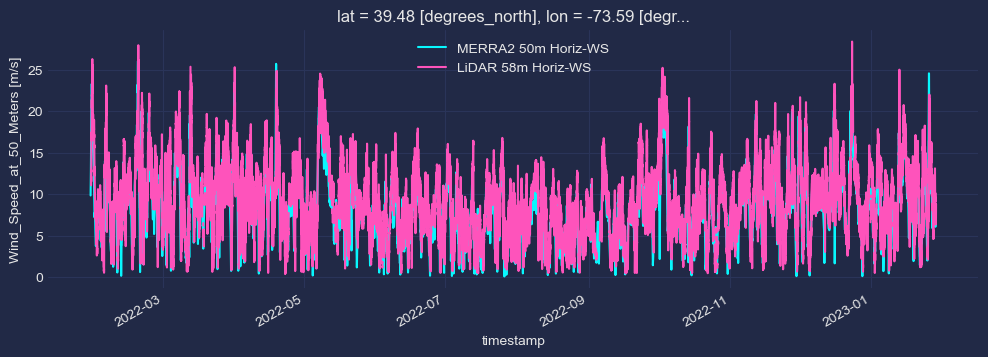

In [204]:
# plot each timeseries
fig, ax = plt.subplots()
wind50m_reanalysis.plot(ax=ax)
lines = wind58m_lidar.plot(ax=ax).lines

plt.legend(lines, ["MERRA2 50m Horiz-WS", "LiDAR 58m Horiz-WS"]);

## Interactive Session Part 2: Impact Variables

* How to convert windspeeds into windpower

### Step 1: hubheight conversion

In [141]:
# simple hubheight conversion
hubheight = 100 # metres

def wind_scaling(wind_timeseries, input_hubheight, target_hubheight):
    """Perform hubeight scaling"""
    alpha = 1/7
    scaling = (target_hubheight / input_hubheight) ** alpha
    return wind_timeseries * scaling
    

wind_rea = wind_scaling(wind50m_reanalysis, 50, hubheight)
wind_obs = wind_scaling(wind58m_lidar, 58, hubheight)

### Step 2: windspeed -> windpower conversion

In [149]:
# simple wind cubed conversion
const = 1e-3
windpower_rea = const * wind_rea ** 3
windpower_obs = const * wind_obs ** 3

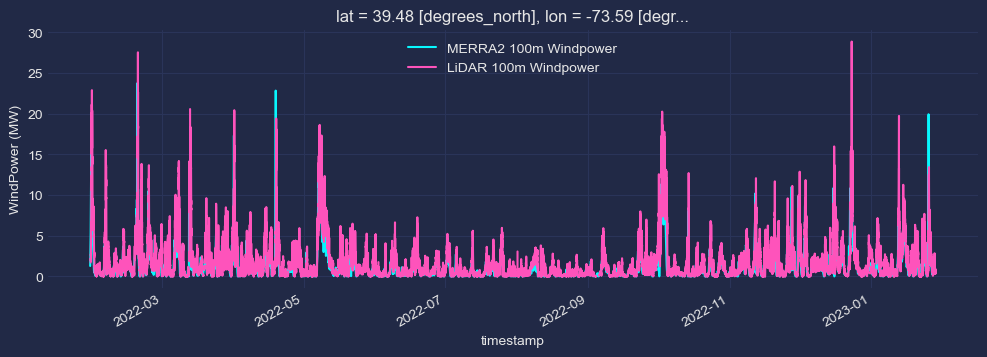

In [150]:
# plot each timeseries
fig, ax = plt.subplots()
windpower_rea.plot(ax=ax)
lines = windpower_obs.plot(ax=ax).lines

plt.legend(lines, [f"MERRA2 {hubheight}m Windpower", f"LiDAR {hubheight}m Windpower"])
plt.ylabel("WindPower (MW)");

### Step 3: evaluate: are the outputs sensible/meaingful?

todo...

In [179]:
# work in progress...
linregress(windpower_rea.values.flatten()[:119], windpower_obs_hourly.values.flatten()[:119])

LinregressResult(slope=1.2742792223077901, intercept=0.18567374690993654, rvalue=0.9829809228173899, pvalue=5.98601109860902e-88, stderr=0.02201678257256447, intercept_stderr=0.10223330537303975)

In [ ]:
# work in progress...

# timeseries scatterplot
windpower_hourly = windpower_obs.resample("1H").mean()
windpower_hourly["r"] = windpower_rea
windpower_hourly.columns = ["lidar", "reanalysis"]

plt.scatter(windpower_rea, windpower_obs_hourly)

plt.xlabel("Windpower Reanalysis 100m (MW)")
plt.ylabel("Windpower LiDAR 100m (MW)")
plt.gca().set_aspect("equal")

rsquared = linregress(windpower_rea, windpower_obs_hourly).rsquared
plt.title(f"R^2 = {rsqaured:.3f}");

### Plot windpower

#### explore tradeoffs
in what ways does reanalysis windpower perform poorly?

## Interactive Session Part 3: ??

* What else do we have time and access to? DTU products? Others?

### More accurate impact conversion

**might be useful to include a schematic picture here showing data -> conversion -> output or similar???**

In [13]:
# using atlite to make the conversion
# todo https://github.com/PyPSA/atlite
# maybe just briefly mention this or add to appendix?

## Learn to drive before taking off in a Ferrari!

<center><img src="images/openclipart_Ferrari-f458-Spider.svg" width="70%"></center>

## Recap of potential pitfalls and misconceptions...

Points here to recap some of the misconceptions / pitfalls we have highlighted, and other things
* Original data might have isses
 - which get **worse** when propagated through an impact chain...
* other points here
* etc.

## Other ways we are incorporating climate services into this demonstration?

Time to show something else with some level of detail?

## Discussion: Next Generation Climate Services

<table width=100% height=100% style="font-size: 38px";><tr>
    <td width=12%>
        <img src="images/pixabay_speak.jpg" width="100%">
    </td>
    <td width=38%>
        <img src="images/ipcc_ar6_ts4.png" width="100%">
    </td>
    <td width=24%>
        <img src="images/wallpaperflare_solar-panels.jpg" width="100%">
    </td>
</tr></table>

[*click here to jump back to the start*](#top)